In [2]:
import nest_asyncio

nest_asyncio.apply()

import collections
import json
from collections import OrderedDict
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tensorflow import TensorSpec
from tensorflow.data import Dataset
from tensorflow_federated.python.simulation.datasets import ClientData

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-12-20 01:04:05.176229: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


b'Hello, World!'

**We start by downloading the MNIST dataset provided by TensorFlow Federated. This data includes the client_ids (i.e. the ID of the client that generated the handwritten digit), allowing for a simulation of the "only positive labels" setting.**

In [3]:
train, test = tff.simulation.datasets.emnist.load_data()
NUM_CLIENTS = len(train.client_ids)
NUM_CLIENTS

3383

In [4]:
train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

**We then convert the MNIST dataset to a federated dataset in which each client only has samples from a single class. This is in order to simulate the "only positive labels" setting in which each client only has access to positives from one class. We choose the most frequent label per client dataset (taken from *most_frequent_labels.json*) to be the positive label for the client. We keep in mind that the overall problem setting is still that of multi-class classification.**

In [5]:
f = open('most_frequent_labels.json')
d = json.load(f)
d2 = {}
for k, v in d.items(): 
    d2[train.client_ids[int(k)]] = v

In [6]:
BATCH_SIZE = 500

def preprocess(dataset):
    def helper(element):
        return (tf.reshape(element['pixels'], [-1, 784]), 
                tf.reshape(element['label'], [-1, 1]))
        # x=tf.reshape(element['pixels'], [-1, 784])
        # y=tf.reshape(element['label'], [-1, 1])
        # return collections.OrderedDict(x=x,y=y)

    return dataset.batch(BATCH_SIZE).map(helper)

In [7]:

def aux(client_id):
    dataset = train.create_tf_dataset_for_client(client_id)
    out = preprocess(dataset)
    out = next(iter(out))
    xs = out[0]
    ys = out[1]
    
    y_ind = tf.where(ys == d2[client_id]) 
    # d2[client_id] corresponds to the most frequent label in that client dataset
    gathered_ys = tf.gather_nd(ys, y_ind)
    
    x_ind = y_ind[:, 0]
    gathered_xs = tf.gather(xs, x_ind)
    
    return ((gathered_xs), (gathered_ys))

In [8]:
def dt_fn(client_id): 
    store = aux(client_id)
    return Dataset.from_tensor_slices({'pixels': store[0], 'label': store[1]})
    # return Dataset.from_tensor_slices((store[0], store[1]))

In [9]:
cd = ClientData.from_clients_and_tf_fn(train.client_ids, dt_fn) 
assert len(cd.client_ids) == NUM_CLIENTS

**We now make additional arrangements to simulate a federated training environment. In a typical federated training scenario, we deal with a potentially very large population of user devices. Of these devices, only a fraction may be available for training (mobile phone connected to internet, charging, etc.) at a given point in time. To simulate this volatility, we sample a random subset of the clients to be involved in each round of training.**

In [10]:
def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x))
    # return [client_data.create_tf_dataset_for_client(x)
      for x in client_ids]

In [11]:
# we create a very simple model for classification 
def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
    ])

def model_fn():
    keras_model = create_keras_model()
    inp_spec = (TensorSpec(shape=(None, 784,), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=inp_spec,           
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [12]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

In [13]:
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[784,10],
      float32[10]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64
  >
>@SERVER)


In [14]:
train_state = training_process.initialize()

**The volatility simulation happens here: at each round of training, we choose a random integer N between 10 and 20 as the number of participants in the training round. We then construct the federated train data for that round by choosing N client_ids.**

In [15]:
def create_data_for_round(): 
    N = np.random.randint(10, 20)
    chosen_client_ids = np.random.randint(0, NUM_CLIENTS, N)
    chosen = [cd.client_ids[i] for i in chosen_client_ids]
    return make_federated_data(cd, chosen)

In [16]:
# first round
federated_train_data = create_data_for_round()
result = training_process.next(train_state, federated_train_data)

In [19]:
losses = []
accuracies = []

In [17]:
train_state = result.state
train_metrics = result.metrics
print('round  1, metrics={}'.format(train_metrics))

round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.19371729), ('loss', 2.302585), ('num_examples', 191), ('num_batches', 15)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


In [24]:
train_metrics['client_work']['train']['sparse_categorical_accuracy']

0.19371729

In [25]:
met = train_metrics['client_work']['train']
losses.append(met['loss'])
accuracies.append(met['sparse_categorical_accuracy'])

In [26]:
NUM_ROUNDS = 101
for round_num in range(2, NUM_ROUNDS):
    print("Creating federated train data for round")
    federated_train_data = create_data_for_round()
    print("Starting next round")
    result = training_process.next(train_state, federated_train_data)
    print("Concluded round {:2d}".format(round_num))
    train_state = result.state
    train_metrics = result.metrics
    print('round {:2d}, metrics={}'.format(round_num, train_metrics))
    met = train_metrics['client_work']['train']
    losses.append(met['loss'])
    accuracies.append(met['sparse_categorical_accuracy'])   

Creating federated train data for round
Starting next round
Concluded round  2
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.25225225), ('loss', 3.3448052), ('num_examples', 222), ('num_batches', 18)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
Creating federated train data for round
Starting next round
Concluded round  3
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.1509434), ('loss', 4.1044226), ('num_examples', 159), ('num_batches', 13)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
Creating federated train data for round
Starting next round
Concluded round  4
round  4, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.50

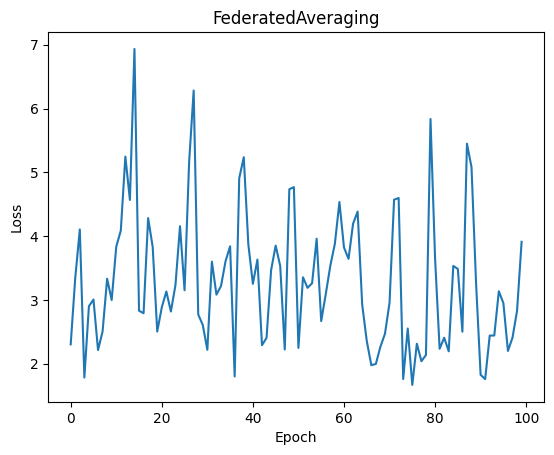

In [30]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("FederatedAveraging")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

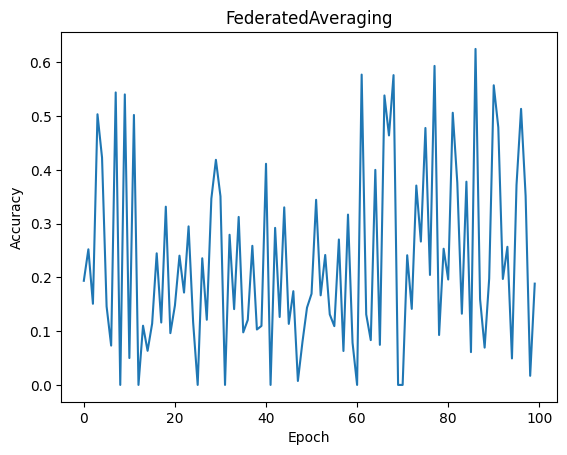

In [31]:
plt.plot(accuracies)
plt.title("FederatedAveraging")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

**As shown above, we observe an extreme fluctuation in the metric 'sparse_categorical_accuracy' when we use the algorithm *FederatedAveraging*. We move on to see whether *FederatedAveragingwithSpreadout* does any better.**